# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [ ]:
def parse_data_line(data_line):
    # Should return a tuple of the label as just positive or negative and the statement
    # e.g. (label, statement)
    label = data_line[1]
    statement = data_line[2]
    return (label, statement)

In [ ]:
import re
import unicodecsv
import collections
# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of str
    tokens = re.split(r"\s",text) # tokensises the strings by separating them wherever the space is
    tokens = [t.lower() for t in tokens] # normalisation by lower casing the tokens generated
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [ ]:
global_feature_dict = {} # A global dictionary of features
i = 0
def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    featureVector = {}

    # here we are using bag of words approach to add features into the feature vector as keys and and weights as its values
    for t in tokens:
        try:
            i = global_feature_dict[t]
        except KeyError:
            i = len(global_feature_dict) + 1
            global_feature_dict[t] = i
        if not t in featureVector.keys():
            featureVector[t] = 1
        else:
            featureVector[t] += 1

    return featureVector

In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [ ]:
#solution
from sklearn.metrics import classification_report

def cross_validate(dataset, folds):
    cv_results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        new_train = []
        if i == 0:
            new_train = dataset[i+fold_size:len(dataset)]
        else:
            new_train = dataset[0:i] + dataset[i+fold_size:len(dataset)]
        classifier = train_classifier(new_train)
        test = []
        label = []
        for s, l in dataset[i:i+fold_size]:
            test.append(s)
            label.append(l)
        predict = predict_labels(test, classifier)
        result = classification_report(label, predict, output_dict = True)
        print('Scores when cross validated on fold', i, '-', i+fold_size, ': \n')
        print('Precision :' , result['weighted avg']['precision'])
        print('Recall :' , result['weighted avg']['recall'])
        print('F1 Score :' , result['weighted avg']['f1-score'])
        print('Accuracy :' , result['accuracy'], '\n')
        if len(cv_results) == 0:
            cv_results.append(result['weighted avg']['precision'])
            cv_results.append(result['weighted avg']['recall'])
            cv_results.append(result['weighted avg']['f1-score'])
            cv_results.append(result['accuracy'])
        else:
            cv_results[0] += result['weighted avg']['precision']
            cv_results[1] += result['weighted avg']['recall']
            cv_results[2] += result['weighted avg']['f1-score']
            cv_results[3] += result['accuracy']

    cv_results[0] /= folds
    cv_results[1] /= folds
    cv_results[2] /= folds
    cv_results[3] /= folds

    return cv_results

In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
64640


In [ ]:
result = cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented
print('The finals results obtained after cross validation are as follows: ', '\n')
print('Precision :' , result[0])
print('Recall :' , result[1])
print('F1 Score :' , result[2])
print('Accuracy :' , result[3])

Fold start on items 0 - 2684
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores when cross validated on fold 0 - 2684 : 

Precision : 0.8552803864090992
Recall : 0.8576751117734724
F1 Score : 0.8558043571607882
Accuracy : 0.8576751117734724 

Fold start on items 2684 - 5368
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores when cross validated on fold 2684 - 5368 : 

Precision : 0.8534884825554981
Recall : 0.8535767511177347
F1 Score : 0.8535324713374961
Accuracy : 0.8535767511177347 

Fold start on items 5368 - 8052
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Scores when cross validated on fold 5368 - 8052 : 

Precision : 0.8105555412914448
Recall : 0.8099850968703428
F1 Score : 0.8102408925247174
Accuracy : 0.8099850968703428 

Fold start on items 8052 - 10736
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores when cross validated on fold 8052 - 10736 : 

Precision : 0.8455935833804838
Recall : 0.8450074515648286
F1 Score : 0.8449050295777984
Accuracy : 0.8450074515648286 

Fold start on items 10736 - 13420
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Scores when cross validated on fold 10736 - 13420 : 

Precision : 0.8450829117959041
Recall : 0.8464977645305514
F1 Score : 0.8455203749173174
Accuracy : 0.8464977645305514 

Fold start on items 13420 - 16104
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores when cross validated on fold 13420 - 16104 : 

Precision : 0.8657287211073171
Recall : 0.86698956780924
F1 Score : 0.8658345416682275
Accuracy : 0.86698956780924 

Fold start on items 16104 - 18788
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores when cross validated on fold 16104 - 18788 : 

Precision : 0.8653686725746941
Recall : 0.8666169895678092
F1 Score : 0.8657118853018044
Accuracy : 0.8666169895678092 

Fold start on items 18788 - 21472
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Scores when cross validated on fold 18788 - 21472 : 

Precision : 0.8473423987310903
Recall : 0.8483606557377049
F1 Score : 0.8477442403590995
Accuracy : 0.8483606557377049 

Fold start on items 21472 - 24156
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores when cross validated on fold 21472 - 24156 : 

Precision : 0.8479233285941491
Recall : 0.849478390461997
F1 Score : 0.8483519378938857
Accuracy : 0.849478390461997 

Fold start on items 24156 - 26840
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Scores when cross validated on fold 24156 - 26840 : 

Precision : 0.8595931907800061
Recall : 0.8609865470852018
F1 Score : 0.8597151973759979
Accuracy : 0.8609865470852018 

The finals results obtained after cross validation are as follows:  

Precision : 0.8495957217219686
Recall : 0.8505174326518883
F1 Score : 0.8497360928117133
Accuracy : 0.8505174326518883


# Question 4: Error Analysis (20 marks)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    # b, t = plt.ylim() # discover the values for bottom and top
    # b += 0.5 # Add 0.5 to the bottom
    # t -= 0.5 # Subtract 0.5 from the top
    # plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    # plt.show()

Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


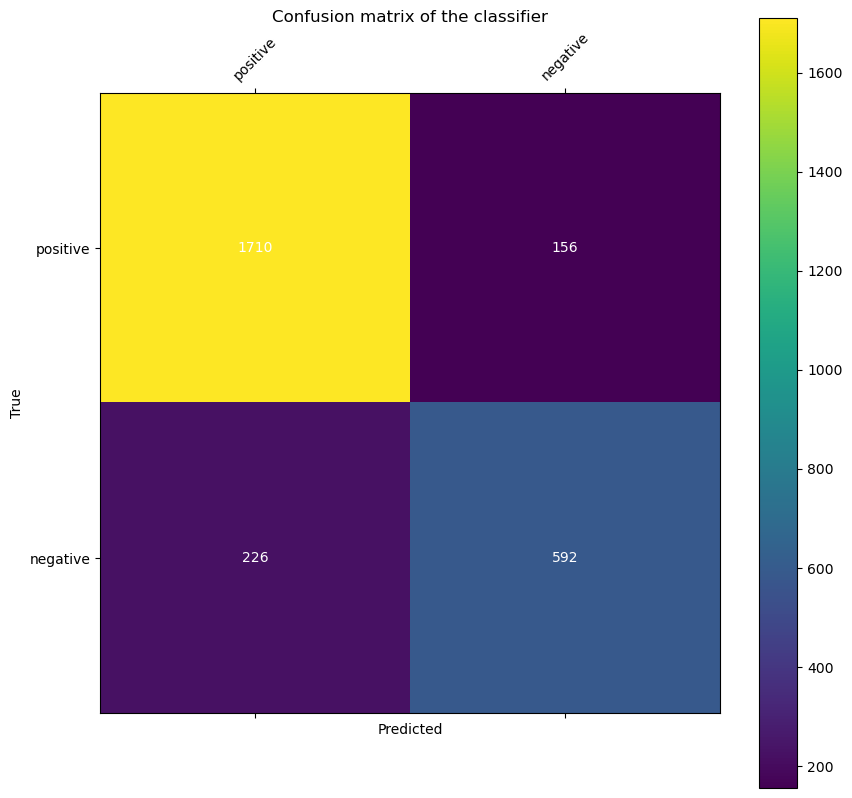

In [ ]:
# Assuming a 10 fold split of the training data
folds = 10
fold_size = int(len(train_data)/folds) + 1
training_data = train_data[fold_size:len(train_data)]
testing_data = train_data[0:fold_size]
classifier = train_classifier(training_data)
test_statments = []
test_labels = []
for s, l in testing_data:
    test_statments.append(s)
    test_labels.append(l)
y_pred = predict_labels(test_statments, classifier)
labels = ['positive', 'negative']
confusion_matrix_heatmap(test_labels, y_pred, labels = labels)

#### Printing False Positives and False Negatives

In [ ]:
false_pos = []
false_neg = []
for i in range(len(y_pred)):
    if test_labels[i] == 'positive' and y_pred[i] == 'negative':
        false_pos.append(i)
    if test_labels[i] == 'negative' and y_pred[i] == 'positive':
        false_neg.append(i)


In [ ]:
print('Statements classified as false positive are:\n')
for i in false_pos:
    print(test_statments[i])
    print('Prediction:', y_pred[i])
    print('Truth:', test_labels[i],'\n')

print('\n*****************************************************\n')

print('Statements classified as false negative are:\n')
for i in false_neg:
    print(test_statments[i])
    print('Prediction:', y_pred[i])
    print('Truth:', test_labels[i],'\n')

Statements classified as false positive are:

{'@jacknonce': 1, 'sorry': 1, ',': 3, 'the': 1, 'blacks': 1, 'i': 1, 'know': 1, 'are': 2, 'actually': 1, 'great': 1, 'successful': 1, 'people': 1, '.': 2, 'they': 2, 'aren': 1, "'": 1, 't': 1, 'taken': 1, 'in': 1, 'by': 1, 'dems': 1, 'bs': 1, 'very': 1, 'smart': 1, 'educated': 1, '!': 1}
Prediction: negative
Truth: positive 

{'i': 1, 'have': 1, 'heard': 1, 'it': 1, 'said': 1, 'that': 1, 'the': 1, '2nd': 1, 'g': 1, 'in': 1, 'snoop': 1, 'dogg': 1, 'represents': 1, 'extra': 1, 'gangsterishness': 1, ',': 1, 'for': 1, 'how': 1, 'else': 1, 'do': 1, 'you': 1, 'explain': 1, 'this': 1, 'particular': 1, 'redundancy': 1, '?': 1}
Prediction: negative
Truth: positive 

{'what': 1, 'i': 1, 'love': 1, 'most': 1, 'about': 1, 'this': 1, 'is': 2, 'that': 1, 'every': 1, 'hag': 1, 'will': 1, 'be': 1, 'on': 1, 'dcum': 1, 'tomorrow': 1, 'talking': 1, 'a': 1, 't': 1, 'how': 1, 'trashy': 1, 'nicki': 1, 'or': 1, 'bey': 1, '.': 1, 'when': 1, 'clearly': 1, '...#vmas

# Questions 5: Optimising pre-processing and feature extraction (30 marks)

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({105: 1, 226: 1, 5: 1, 750: 1, 1050: 1, 60: 1, 30049: 1, 96: 1, 59: 1, 55395: 1, 55396: 1, 287: 1, 979: 1, 55397: 1, 110: 1, 172: 1, 148: 1, 19090: 1, 23: 1, 2778: 1}, 'positive')
Training Classifier...


/Users/harshmalik/tensorflow-test/env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Done training!
Precision: 0.852594
Recall: 0.853757
F Score:0.852966
